# Energy System Modelling - Tutorial III.2

**Settings**

In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
solver = "glpk"

***
**(a) Build a network in PyPSA with the two buses North and South and attach the load at each bus and attach the wind and solar generators with availability according to $g^N_w(t) = c_w(1+A_w\sin \omega_w t)$ and $g^S_s(t) = c_s(1+A_s\sin \omega_s t)$ for a year (you have to call [`network.set_snapshots`](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/api_reference.html?highlight=set_snapshots) to select a year) and with `p_nom_extendable=True`. As help you should have a look at the [PyPSA documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/index.html) and the [minimal lopf example](https://www.pypsa.org/examples/minimal_example_lopf.html), understand what the [components documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [LOPF documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/optimal_power_flow.html).**

> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

Initialize network

In [3]:
network = pypsa.Network()

Add North and South bus

In [4]:
network.add("Bus",
            "North",
            carrier="AC")

In [ ]:
???

Attach constant load

In [5]:
network.add("Load",
            "North Load",
            bus="North",
            p_set=20e3)

In [6]:
???

Object `?` not found.


Attach renewable generators according to given parameters

In [7]:
network.set_snapshots(np.arange(0, 4*7*24))

In [8]:
Cfw = 0.3
Aw = 0.9
omegaw = 2*np.pi/(7*24)

Cfs = 0.12
As = 1.
omegas = 2*np.pi/24

GNwt = Cfw * (1+Aw*np.sin(omegaw*network.snapshots.to_series()))
GSst = Cfs * (1+As*np.sin(omegas*network.snapshots.to_series()))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


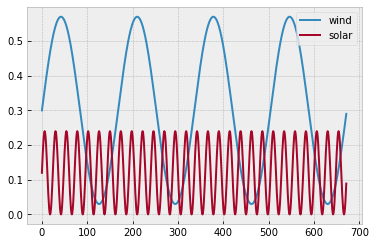

In [9]:
pd.concat([GNwt, GSst], keys=['wind', 'solar'], axis=1).loc[:4*7*24].plot()

In [10]:
network.add("Generator",
            "Wind",
            bus="North",
            p_nom_extendable=True,
            capital_cost=1.2e6,
            p_max_pu=GNwt)

In [ ]:
???

***
**(b) Attach extendable storage units at the North and the South! The storages have to be modelled as an `H2-bus` (a bus with `carrier='H2'`) linked to the `AC-bus` North with a `Link` where `p_nom_extendable=True` with the `capital_cost` of the power capacity and an also extendable `Store` with the `capital_cost` of the energy capacity, for instance. The losses can be set on the links as `efficiency`.**

In [ ]:
for bus in ["North", "South"]:
    
    # H2 storage
    network.add("Bus",
                bus + " H2",
                ???
               )
    
    network.add("Store",
                bus + " H2 St.",
                bus=bus + " H2",
                ???
               )
    
    network.add("Link",
                bus + "->H2",
                bus0=bus, bus1=bus + " H2",
                ???
               )
    
    network.add("Link",
                "H2->" + bus,
                bus0=bus + " H2", bus1=bus,
                ???
               )
    
    # Battery storage
    network.add("Bus",
                bus + " Battery",
                ???
               )
    
    network.add("Store",
                bus + " Battery St.",
                bus=bus + " Battery",
                ???
               )
    
    network.add("Link",
                bus + "<->Battery",
                bus0=bus, bus1=bus + " Battery",
                ???
               )

***
**(c) Run an investment optimization by calling the `lopf` function.**

In [12]:
network.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 800000000000.0
  Upper bound: 800000000000.0
  Number of objectives: 1
  Number of constraints: 2017
  Number of variables: 674
  Number of nonzeros: 2689
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.042986154556274414
# ----------------------------------------------------------
#   Solution Information
# ----------

('ok', 'optimal')

***
**(d) How do your results `objective` and `{generators,stores,links}.p_nom_opt` compare with the results of III.1(d)?** 

Objective value

Capacities for wind and solar.

Store and dispatch power capacity.

Energy capacities.

Plot the storage energy states over time

***
**(e) Now we lift the restriction against transmission and allow North and South to bridge their 500 km
separation with a transmission line. How does the cost optimal technology mix change?**

Add extendable link between North and South:

Run LOPF:

Get the results `objective` and `{generators,stores,links}.p_nom_opt`:

Objective value

Capacities for wind and solar.

Store and dispatch power capacity.

Energy capacities.

Plot the storage energy states over time

***
**(e) Replace the approximated availability time-series of the wind and the solar generators with the ones from `availability.csv` computed from reanalysis weather data and re-run the LOPF. Compare the results! Explain the differences by looking at the cumulative variations relative to the mean of the availability time-series!**

Adapt the network to new availabiltiy data:

In [ ]:
network.remove("Generator", "Wind")
network.remove("Generator", "Solar")

In [ ]:
availability = pd.read_csv("data/availability.csv", index_col=0, parse_dates=True)
availability.head()

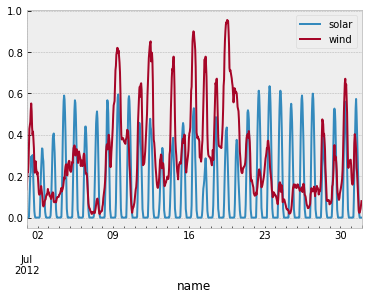

In [30]:
availability.loc["2012-7"].plot()

In [31]:
availability.loc["2012-7"].index

DatetimeIndex(['2012-07-01 00:00:00', '2012-07-01 01:00:00',
               '2012-07-01 02:00:00', '2012-07-01 03:00:00',
               '2012-07-01 04:00:00', '2012-07-01 05:00:00',
               '2012-07-01 06:00:00', '2012-07-01 07:00:00',
               '2012-07-01 08:00:00', '2012-07-01 09:00:00',
               ...
               '2012-07-31 14:00:00', '2012-07-31 15:00:00',
               '2012-07-31 16:00:00', '2012-07-31 17:00:00',
               '2012-07-31 18:00:00', '2012-07-31 19:00:00',
               '2012-07-31 20:00:00', '2012-07-31 21:00:00',
               '2012-07-31 22:00:00', '2012-07-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=744, freq=None)

Set snapshots of the network using the availability time series for July 2012.

Add wind generator with availability time series

Add solar generator with availability time series

Run LOPF:

Get the results `objective` and `{generators,stores,links}.p_nom_opt` with real availability:

Objective value

Capacities for wind and solar.

Store and dispatch power capacity.

Energy capacities.

Plot the storage energy states over time

Explain the differences by looking at the cumulative variations relative to the mean of the availability time-series.

***
**(f) Compare all results for all three scenarios in terms of total system cost, renewable generation capacity, storage power capacity and storage energy capacity!**

> **Remark:** For example, you can use bar charts `plt.bar(...)` or `df.plot.bar()` to visualize the differences.